# Footprint calling and plotting of a single DHS

This notebook shows an example of how call footprints on a single region and plot the results. This code recreates **Extended Data Fig. 1** from Vierstra *et al.* 2020.

The plotting performed in this example relies on the python package `genome-tools`, which provides an assortment of ways to plot genomic data. You can find a short tutorial in the form of a python notebook [here](https://github.com/jvierstra/genome-tools/blob/master/examples/UsageExamples.ipynb) on the various features.

In [1]:
import numpy as np
import pandas as pd
import scipy as sc
import scipy.stats as stats

import pysam

from genome_tools import bed, genomic_interval
from footprint_tools import cutcounts
from footprint_tools.modeling import bias, predict, dispersion
from footprint_tools.stats import fdr, windowing, utils

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator

In [2]:
# We can grab the FASTA, BAM and dispersion model files remotely with the API
fasta_file = "https://resources.altius.org/~jvierstra/projects/footprinting.2020/hg38.all.fa"

base_url="https://resources.altius.org/~jvierstra/projects/footprinting.2020/per.dataset/CD20+-DS18208/"
bam_file=base_url + "reads.bam"
disp_model_file=base_url + "dm.json"

!curl https://resources.altius.org/~jvierstra/projects/footprinting.2020/vierstra_et_al.6mer-model.txt -o bm.txt
bias_model_file = "bm.txt" 

# This is the genomic region to plot data
interval = genomic_interval('chr19', 48363826, 48364602)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 95802  100 95802    0     0  1264k      0 --:--:-- --:--:-- --:--:-- 1264k


## Perform footprint detection

In [3]:
counts_reader = cutcounts.bamfile(bam_file)
fasta_reader = pysam.FastaFile(fasta_file)
dm = dispersion.load_dispersion_model(disp_model_file)
bm = bias.kmer_model(bias_model_file)

predictor = predict.prediction(counts_reader, fasta_reader, bm, half_win_width = 5, smoothing_half_win_width = 50, smoothing_clip = 0.01)
(obs_counts, exp_counts, win_counts) = predictor.compute(interval)
    
# Compute expected counts
# Note: windowed counts are used to generated expected counts
# and not used directly in statistical testing
obs = obs_counts['+'][1:] + obs_counts['-'][:-1]
exp = exp_counts['+'][1:] + exp_counts['-'][:-1]
win = win_counts['+'][1:] + win_counts['-'][:-1]

# Per-nucleotide p-values
pvals = dm.p_values(exp, obs)

# Windowed p-values with Stouffer's Z
winpvals_func = lambda x: windowing.stouffers_z(np.ascontiguousarray(x), 3)
winpvals = np.array(winpvals_func(pvals))

# Resample from expected distributions for emperical adjustment of p-values for multiple testing
_, pvals_null = dm.sample(exp, 1000)
winpvals_null = np.apply_along_axis(winpvals_func, 0, pvals_null)
fpr = fdr.emperical_fdr(winpvals_null, winpvals)

# Call footprints at 0.01 FPR
fps = [genomic_interval(interval.chrom, interval.start+x, interval.start+y) 
    for x, y in utils.segment(np.array(fpr), 0.01, 3, decreasing=True) ]


## Plot genomic footprinting data

In [ ]:
from genome_tools.plotting import pwm, ideogram
from genome_tools.plotting import gencode_annotation_track, continuous_data_track, segment_track
from genome_tools.plotting.connectors import zoom_effect

def make_nb_plot(e, o, dm, ax, lo = 0, hi = 125):
    """Plots the dispersion model negative binomial distribution"""
    
    xx = np.arange(lo, hi)
    
    mu = dm.fit_mu(e)
    r = dm.fit_r(e)
    p = r/(r+mu)

    yy = sc.stats.nbinom.pmf(xx, r, p)
    ax.plot(xx, yy, label = "Expected cleavage rate")
    ax.fill_between(xx[:int(o)], 0, yy[:int(o)], edgecolor = 'none', label="Prob. observed")
    
    ax.set_xlim(left = lo, right = hi)
    
    ax.set_xlabel("Cleavages")
    ax.set_ylabel("Density")

    [ax.spines[loc].set_color("none") for loc in ["top", "right"]]
    ax.xaxis.set_ticks_position("bottom")
    ax.xaxis.set_tick_params(direction = "out")
    ax.xaxis.set(major_locator = MaxNLocator(4))
    
    ax.yaxis.set_ticks_position("left")
    ax.yaxis.set_tick_params(direction = "out")
    ax.yaxis.set(major_locator = MaxNLocator(3))
    ax.set_ylim(bottom=0)

In [10]:
for fp in fps:
    print(fp)

chr19	48363851	48363885
chr19	48363926	48363945
chr19	48363983	48364004
chr19	48364029	48364045
chr19	48364049	48364071
chr19	48364094	48364116
chr19	48364119	48364128
chr19	48364142	48364158
chr19	48364177	48364190
chr19	48364239	48364259
chr19	48364286	48364305
chr19	48364338	48364353
chr19	48364404	48364421
chr19	48364451	48364459
chr19	48364478	48364483
chr19	48364544	48364562


## Auto-correlation analysis of *p*-values

The following computes the Pearson's correlations between null p-values at offsets up to 25 bp.

In [4]:
m, n = pvals_null.shape

ts = range(0, 26)

cor_mat = np.ones((m, len(ts)), dtype = float)
for i in range(m):
    for t in ts[1:]:        
        x = pvals_null[:-t, i]
        y = pvals_null[t:,i]
        cor_mat[i, t] = np.corrcoef(x, y)[0, 1]

err = np.percentile(cor_mat, [10, 90], axis = 0)

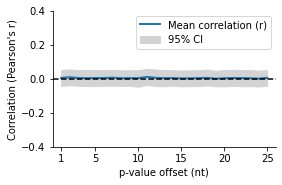

In [12]:
fig, ax = plt.subplots()

ax.plot(ts[1:], np.mean(cor_mat, axis = 0)[1:], lw = 2, label = "Mean correlation (r)")
ax.fill_between(ts[1:], err[0,1:], err[1,1:], color = "lightgrey", label = "95% CI")

ax.axhline(0.0, ls = "--", color = 'black')

ax.set_xlim(0, 26)
ax.set_ylim(-0.4, 0.4)

ax.set_xlabel("p-value offset (nt)")
ax.set_ylabel("Correlation (Pearson's r)")

[ax.spines[loc].set_color("none") for loc in ["top", "right"]]

ax.xaxis.set_ticks([1, 5, 10, 15, 20, 25])
ax.xaxis.set_ticks_position("bottom")
ax.xaxis.set_tick_params(direction = "out")

ax.yaxis.set_ticks_position("left")
ax.yaxis.set_tick_params(direction = "out")
ax.yaxis.set(major_locator = MaxNLocator(4))
    
ax.legend()

fig.set_size_inches(4, 2.5)

plt.show()

## Plot obserbved and null *p*-value distributions

In [ ]:
fig = plt.figure()
fig.set_size_inches(3, 6)

gs = gridspec.GridSpec(3, 1, hspace=0.4)

ax = fig.add_subplot(gs[0, 0])
ax.hist(winpvals, bins = np.arange(0, 1.05, 0.05), lw = 0, facecolor = "tomato", density = True)
ax.set_ylim(bottom = 0, top = 7.5)

ax.set_xlabel("Windowed p-value (observed)")
ax.set_ylabel("Density")

[ax.spines[loc].set_color('none') for loc in ["right", "top"]]
ax.xaxis.set(ticks_position = 'bottom')
ax.xaxis.set_tick_params(direction = "out")

ax.yaxis.set(ticks_position = 'left', major_locator = MaxNLocator(4))
ax.yaxis.set_tick_params(direction = "out")

ax.set_ylim(bottom = 0, top = 7.5)

ax = fig.add_subplot(gs[1, 0])
ax.hist(winpvals_null[:,1], bins = np.arange(0, 1.05, 0.05), lw = 0, facecolor = "mediumpurple", density = True)
#ax.hist(winpvals_null, bins = np.arange(0, 1.05, 0.05), lw = 0, facecolor = "green", normed = True)
ax.set_ylim(bottom = 0, top = 7.5)

ax.set_xlabel("Windowed p-value (resampled null)")
ax.set_ylabel("Density")

[ax.spines[loc].set_color('none') for loc in ["right", "top"]]
ax.xaxis.set(ticks_position = 'bottom')
ax.xaxis.set_tick_params(direction = "out")

ax.yaxis.set(ticks_position = 'left', major_locator = MaxNLocator(4))
ax.yaxis.set_tick_params(direction = "out")

ax.margins(x = 0.025)

ax = fig.add_subplot(gs[2, 0])
ax.plot(np.sort(fpr), lw = 3)

[ax.spines[loc].set_color('none') for loc in ["right", "top"]]
ax.xaxis.set(ticks_position = 'bottom')
ax.xaxis.set_tick_params(direction = "out")

ax.yaxis.set(ticks_position = 'left', ticks = [ 0.0, 0.25, 0.5, 0.75, 1.0])
ax.yaxis.set_tick_params(direction = "out")

ax.margins(x = 0.025)

ax.set_xlabel("Nucleotides sorted by p-value")
ax.set_ylabel("False positive rate")

plt.show()